# FastHTML By Example

> An introduction to FastHTML from the ground up, with four complete examples

- order: 2

This tutorial provides an alternate introduction to FastHTML by building out example applications. We also illustrate how to use FastHTML foundations to create custom web apps. Finally, this document serves as minimal context for a LLM to turn it into a FastHTML assistant.

Let's get started.

## FastHTML Basics

FastHTML is *just Python*. You can install it with `pip install python-fasthtml`. Extensions/components built for it can likewise be distributed via PyPI or as simple Python files.

The core usage of FastHTML is to define routes, and then to define what to do at each route. This is similar to the [FastAPI](https://fastapi.tiangolo.com/) web framework (in fact we implemented much of the functionality to match the FastAPI usage examples), but where FastAPI focuses on returning JSON data to build APIs, FastHTML focuses on returning HTML data.

Here's a simple FastHTML app that returns a "Hello, World" message:

In [ ]:
from fasthtml.common import FastHTML, serve

app = FastHTML()

@app.get("/")
def home():
    return "<h1>Hello, World</h1>"

serve()

To run this app, place it in a file, say `app.py`, and then run it with `python app.py`.

```
INFO:     Will watch for changes in these directories: ['/home/jonathan/fasthtml-example']
INFO:     Uvicorn running on http://127.0.0.1:5001 (Press CTRL+C to quit)
INFO:     Started reloader process [871942] using WatchFiles
INFO:     Started server process [871945]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
```

If you navigate to [http://127.0.0.1:5001](http://127.0.0.1:5001) in a browser, you'll see your "Hello, World". If you edit the `app.py` file and save it, the server will reload and you'll see the updated message when you refresh the page in your browser.

## Constructing HTML

Notice we wrote some HTML in the previous example. We don't want to do that! Some web frameworks require that you learn HTML, CSS, JavaScript AND some templating language AND python. We want to do as much as possible with just one language. Fortunately, the Python module [fastcore.xml](https://fastcore.fast.ai/xml.html) has all we need for constructing HTML from Python, and FastHTML includes all the tags you need to get started. For example:

In [ ]:
from fasthtml.common import *
page = Html(
    Head(Title('Some page')),
    Body(Div('Some text, ', A('A link', href='https://example.com'), Img(src="https://placehold.co/200"), cls='myclass')))
print(to_xml(page))

<!doctype html></!doctype>

<html>
  <head>
    <title>Some page</title>
  </head>
  <body>
    <div class="myclass">
Some text, 
      <a href="https://example.com">A link</a>
      <img src="https://placehold.co/200">
    </div>
  </body>
</html>



In [ ]:
show(page)

If that `import *` worries you, you can always import only the tags you need. 

FastHTML is smart enough to know about fastcore.xml, and so you don't need to use the `to_xml` function to convert your FT objects to HTML. You can just return them as you would any other Python object. For example, if we modify our previous example to use fastcore.xml, we can return an FT object directly:

In [ ]:
from fasthtml.common import *
app = FastHTML()

@app.get("/")
def home():
    page = Html(
        Head(Title('Some page')),
        Body(Div('Some text, ', A('A link', href='https://example.com'), Img(src="https://placehold.co/200"), cls='myclass')))
    return page

serve()

This will render the HTML in the browser.

For debugging, you can right-click on the rendered HTML in the browser and select "Inspect" to see the underlying HTML that was generated. There you'll also find the 'network' tab, which shows you the requests that were made to render the page. Refresh and look for the request to `127.0.0.1` - and you'll see it's just a `GET` request to `/`, and the response body is the HTML you just returned.

:::{.callout-tip}
# Live Reloading
You can also enable [live reloading](../ref/live_reload.ipynb) so you don't have to manually refresh your browser to view updates.
:::

You can also use Starlette's `TestClient` to try it out in a notebook: 

In [ ]:
from starlette.testclient import TestClient
client = TestClient(app)
r = client.get("/")
print(r.text)

<html>
  <head><title>Some page</title>
</head>
  <body><div class="myclass">
Some text, 
  <a href="https://example.com">A link</a>
  <img src="https://placehold.co/200">
</div>
</body>
</html>



FastHTML wraps things in an Html tag if you don't do it yourself (unless the request comes from htmx, in which case you get the element directly). 
See [FT objects and HTML](#ft-objects-and-html) for more on creating custom components or adding HTML rendering to existing Python objects.
To give the page a non-default title, return a Title before your main content:

In [ ]:
app = FastHTML()

@app.get("/")
def home():
    return Title("Page Demo"), Div(H1('Hello, World'), P('Some text'), P('Some more text'))

client = TestClient(app)
print(client.get("/").text)

<!doctype html></!doctype>

<html>
  <head>
    <title>Page Demo</title>
    <meta charset="utf-8"></meta>
    <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover"></meta>
    <script src="https://unpkg.com/htmx.org@next/dist/htmx.min.js"></script>
    <script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@1.3.0/surreal.js"></script>
    <script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script>
  </head>
  <body>
<div>
  <h1>Hello, World</h1>
  <p>Some text</p>
  <p>Some more text</p>
</div>
  </body>
</html>



We'll use this pattern often in the examples to follow.

## Defining Routes



The HTTP protocol defines a number of methods ('verbs') to send requests to a server. The most common are GET, POST, PUT, DELETE, and HEAD. We saw 'GET' in action before - when you navigate to a URL, you're making a GET request to that URL. We can do different things on a route for different HTTP methods. For example:

```python
@app.route("/", methods='get')
def home():
    return H1('Hello, World')

@app.route("/", methods=['post', 'put'])
def post_or_put():
    return "got a POST or PUT request"
```

This says that when someone navigates to the root URL "/" (i.e. sends a GET request), they will see the big "Hello, World" heading. When someone submits a POST or PUT request to the same URL, the server should return the string "got a post or put request".

:::{.callout-tip}
## Test the POST request

You can test the POST request with `curl -X POST http://127.0.0.1:8000 -d "some data"`. This sends some data to the server, you should see the response "got a post or put request" printed in the terminal.
:::

There are a few other ways you can specify the route+method - FastHTML has `.get`, `.post`, etc. as shorthand for `route(..., methods=['get'])`, etc.

In [ ]:
@app.get("/")
def my_function():
    return "Hello World from a GET request"

 Or you can use the `@rt` decorator without a method but specify the method with the name of the function. For example:

In [ ]:
rt = app.route

@rt("/")
def post():
    return "Hello World from a POST request"

In [ ]:
client.post("/").text

'Hello World from a POST request'

You're welcome to pick whichever style you prefer. Using routes lets you show different content on different pages - '/home', '/about' and so on. You can also respond differently to different kinds of requests to the same route, as shown above. You can also pass data via the route:

:::{.panel-tabset}

## `@app.get`

In [ ]:
@app.get("/greet/{nm}")
def greet(nm:str):
    return f"Good day to you, {nm}!"

client.get("/greet/Dave").text

'Good day to you, Dave!'

## `@rt`

In [ ]:
@rt("/greet/{nm}")
def get(nm:str):
    return f"Good day to you, {nm}!"

client.get("/greet/Dave").text

'Good day to you, Dave!'

:::

More on this in the [More on Routing and Request Parameters](#more-on-routing-and-request-parameters) section, which goes deeper into the different ways to get information from a request.

## Styling Basics

Plain HTML probably isn't quite what you imagine when you visualize your beautiful web app. CSS is the go-to language for styling HTML. But again, we don't want to learn extra languages unless we absolutely have to! Fortunately, there are ways to get much more visually appealing sites by relying on the hard work of others, using existing CSS libraries. One of our favourites is [PicoCSS](https://picocss.com/). A common way to add CSS files to web pages is to use a [`<link>`](https://www.w3schools.com/tags/tag_link.asp) tag inside your [HTML header](https://www.w3schools.com/tags/tag_header.asp), like this:

```html
<header>
    ...
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@picocss/pico@latest/css/pico.min.css">
</header>
```

For convenience, FastHTML already defines a Pico component for you with `picolink`: 

In [ ]:
print(to_xml(picolink))

<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@picocss/pico@latest/css/pico.min.css">

<style>:root { --pico-font-size: 100%; }</style>



:::{.callout-note}
`picolink` also includes a `<style>` tag, as we found that setting the font-size to 100% to be a good default.  We show you how to override this below.
:::

Since we typically want CSS styling on all pages of our app, FastHTML lets you define a shared HTML header with the `hdrs` argument as shown below:

In [ ]:
from fasthtml.common import *
css = Style(':root {--pico-font-size:90%,--pico-font-family: Pacifico, cursive;}') # <1>
app = FastHTML(hdrs=(picolink, css)) # <2>

@app.route("/")
def get():
    return (Title("Hello World"), 
            Main(H1('Hello, World'), cls="container")) # <3>

1. Custom styling to override the pico defaults
2. Define shared headers for all pages
3. As per the [pico docs](https://picocss.com/docs), we put all of our content inside a `<main>` tag with a class of `container`:

:::{.callout-note}

## Returning Tuples

We're returning a tuple here (a title and the main page). Returning a tuple, list, `FT` object, or an object with a `__ft__` method tells FastHTML to turn the main body into a full HTML page that includes the headers (including the pico link and our custom css) which we passed in. This only occurs if the request isn't from HTMX (for HTMX requests we need only return the rendered components).

:::

You can check out the Pico [examples](https://picocss.com/examples) page to see how different elements will look. If everything is working, the page should now render nice text with our custom font, and it should respect the user's light/dark mode preferences too.



If you want to [override the default styles](https://picocss.com/docs/css-variables) or add more custom CSS, you can do so by adding a `<style>` tag to the headers as shown above. So you are allowed to write CSS to your heart's content - we just want to make sure you don't necessarily have to! Later on we'll see examples using other component libraries and tailwind css to do more fancy styling things, along with tips to get an LLM to write all those fiddly bits so you don't have to.

## Web Page -> Web App

Showing content is all well and good, but we typically expect a bit more *interactivity* from something calling itself a web app! So, let's add a few different pages, and use a form to let users add messages to a list:

In [ ]:
app = FastHTML()
messages = ["This is a message, which will get rendered as a paragraph"]

@app.get("/")
def home():
    return Main(H1('Messages'), 
                *[P(msg) for msg in messages],
                A("Link to Page 2 (to add messages)", href="/page2"))

@app.get("/page2")
def page2():
    return Main(P("Add a message with the form below:"),
                Form(Input(type="text", name="data"),
                     Button("Submit"),
                     action="/", method="post"))

@app.post("/")
def add_message(data:str):
    messages.append(data)
    return home()

We re-render the entire homepage to show the newly added message. This is fine, but modern web apps often don't re-render the entire page, they just update a part of the page. In fact even very complicated applications are often implemented as 'Single Page Apps' (SPAs). This is where HTMX comes in.

## HTMX

[HTMX](https://htmx.org/) addresses some key limitations of HTML. In vanilla HTML, links can trigger a GET request to show a new page, and forms can send requests containing data to the server. A lot of 'Web 1.0' design revolved around ways to use these to do everything we wanted. But why should only *some* elements be allowed to trigger requests? And why should we refresh the *entire page* with the result each time one does? HTMX extends HTML to allow us to trigger requests from *any* element on all kinds of events, and to update a part of the page without refreshing the entire page. It's a powerful tool for building modern web apps.

It does this by adding attributes to HTML tags to make them do things. For example, here's a page with a counter and a button that increments it:

In [ ]:
app = FastHTML()

count = 0

@app.get("/")
def home():
    return Title("Count Demo"), Main(
        H1("Count Demo"),
        P(f"Count is set to {count}", id="count"),
        Button("Increment", hx_post="/increment", hx_target="#count", hx_swap="innerHTML")
    )

@app.post("/increment")
def increment():
    print("incrementing")
    global count
    count += 1
    return f"Count is set to {count}"

The button triggers a POST request to `/increment` (since we set `hx_post="/increment"`), which increments the count and returns the new count. The `hx_target` attribute tells HTMX where to put the result. If no target is specified it replaces the element that triggered the request. The `hx_swap` attribute specifies how it adds the result to the page. Useful options are:

- *`innerHTML`*: Replace the target element's content with the result.
- *`outerHTML`*: Replace the target element with the result.
- *`beforebegin`*: Insert the result before the target element.
- *`beforeend`*: Insert the result inside the target element, after its last child.
- *`afterbegin`*: Insert the result inside the target element, before its first child.
- *`afterend`*: Insert the result after the target element.

You can also use an hx_swap of `delete` to delete the target element regardless of response, or of `none` to do nothing.

By default, requests are triggered by the “natural” event of an element - click in the case of a button (and most other elements). You can also specify different triggers, along with various modifiers - see the [HTMX docs](https://htmx.org/docs/#triggers) for more.

This pattern of having elements trigger requests that modify or replace other elements is a key part of the HTMX philosophy. It takes a little getting used to, but once mastered it is extremely powerful.

### Replacing Elements Besides the Target

Sometimes having a single target is not enough, and we'd like to specify some additional elements to update or remove. In these cases, returning elements with an id that matches the element to be replaced and `hx_swap_oob='true'` will replace those elements too. We'll use this in the next example to clear an input field when we submit a form.

## Full Example #1 - ToDo App

The canonical demo web app! A TODO list. Rather than create yet another variant for this tutorial, we recommend starting with this video tutorial from Jeremy:

{{< video https://www.youtube.com/embed/Auqrm7WFc0I >}}

We've made a number of variants of this app - so in addition to the version shown in the video you can browse [this](https://github.com/AnswerDotAI/fasthtml-tut) series of examples with increasing complexity, the heavily-commented ["idiomatic" version here](https://github.com/AnswerDotAI/fasthtml/blob/main/examples/adv_app.py), and the [example](https://github.com/AnswerDotAI/fasthtml-example/tree/main/01_todo_app) linked from the [FastHTML homepage](https://fastht.ml/).

## Full Example #2 - Image Generation App

Let's create an image generation app. We'd like to wrap a text-to-image model in a nice UI, where the user can type in a prompt and see a generated image appear. We'll use a model hosted by [Replicate](https://replicate.com) to actually generate the images. Let's start with the homepage, with a form to submit prompts and a div to hold the generated images:

```python
# Main page
@app.get("/")
def get():
    inp = Input(id="new-prompt", name="prompt", placeholder="Enter a prompt")
    add = Form(Group(inp, Button("Generate")), hx_post="/", target_id='gen-list', hx_swap="afterbegin")
    gen_list = Div(id='gen-list')
    return Title('Image Generation Demo'), Main(H1('Magic Image Generation'), add, gen_list, cls='container')
```

Submitting the form will trigger a POST request to `/`, so next we need to generate an image and add it to the list. One problem: generating images is slow! We'll start the generation in a separate thread, but this now surfaces a different problem: we want to update the UI right away, but our image will only be ready a few seconds later. This is a common pattern - think about how often you see a loading spinner online. We need a way to return a temporary bit of UI which will eventually be replaced by the final image. Here's how we might do this:

```python
def generation_preview(id):
    if os.path.exists(f"gens/{id}.png"):
        return Div(Img(src=f"/gens/{id}.png"), id=f'gen-{id}')
    else:
        return Div("Generating...", id=f'gen-{id}', 
                   hx_post=f"/generations/{id}",
                   hx_trigger='every 1s', hx_swap='outerHTML')
    
@app.post("/generations/{id}")
def get(id:int): return generation_preview(id)

@app.post("/")
def post(prompt:str):
    id = len(generations)
    generate_and_save(prompt, id)
    generations.append(prompt)
    clear_input =  Input(id="new-prompt", name="prompt", placeholder="Enter a prompt", hx_swap_oob='true')
    return generation_preview(id), clear_input

@threaded
def generate_and_save(prompt, id): ... 
```

The form sends the prompt to the `/` route, which starts the generation in a separate thread then returns two things:

- A generation preview element that will be added to the top of the `gen-list` div (since that is the target_id of the form which triggered the request)
- An input field that will replace the form's input field (that has the same id), using the hx_swap_oob='true' trick. This clears the prompt field so the user can type another prompt.

The generation preview first returns a temporary "Generating..." message, which polls the `/generations/{id}` route every second. This is done by setting hx_post to the route and hx_trigger to 'every 1s'. The `/generations/{id}` route returns the preview element every second until the image is ready, at which point it returns the final image. Since the final image replaces the temporary one (hx_swap='outerHTML'), the polling stops running and the generation preview is now complete.

This works nicely - the user can submit several prompts without having to wait for the first one to generate, and as the images become available they are added to the list. You can see the full code of this version [here](https://github.com/AnswerDotAI/fasthtml-example/blob/main/image_app_simple/draft1.py).


### Again, with Style

The app is functional, but can be improved. The [next version](https://github.com/AnswerDotAI/fasthtml-example/blob/main/image_app_simple/main.py) adds more stylish generation previews, lays out the images in a grid layout that is responsive to different screen sizes, and adds a database to track generations and make them persistent. The database part is very similar to the todo list example, so let's just quickly look at how we add the nice grid layout. This is what the result looks like:

![image.png](https://github.com/AnswerDotAI/fasthtml-example/blob/main/image_app_simple/screenshot.png?raw=true)



Step one was looking around for existing components. The Pico CSS library we've been using has a rudimentary grid but recommends using an alternative layout system. One of the options listed was [Flexbox](http://flexboxgrid.com/). 

To use Flexbox you create a "row" with one or more elements. You can specify how wide things should be with a specific syntax in the class name. For example, `col-xs-12` means a box that will take up 12 columns (out of 12 total) of the row on extra small screens, `col-sm-6` means a column that will take up 6 columns of the row on small screens, and so on. So if you want four columns on large screens you would use `col-lg-3` for each item (i.e. each item is using 3 columns out of 12). 

```html
<div class="row">
    <div class="col-xs-12">
        <div class="box">This takes up the full width</div>
    </div>
</div>
```

This was non-intuitive to me. Thankfully ChatGPT et al know web stuff quite well, and we can also experiment in a notebook to test things out:

In [ ]:
grid = Html(
    Link(rel="stylesheet", href="https://cdnjs.cloudflare.com/ajax/libs/flexboxgrid/6.3.1/flexboxgrid.min.css", type="text/css"),
    Div(
        Div(Div("This takes up the full width", cls="box", style="background-color: #800000;"), cls="col-xs-12"),
        Div(Div("This takes up half", cls="box", style="background-color: #008000;"), cls="col-xs-6"),
        Div(Div("This takes up half", cls="box", style="background-color: #0000B0;"), cls="col-xs-6"),
        cls="row", style="color: #fff;"
    )
)
show(grid)


Aside: when in doubt with CSS stuff, add a background color or a border so you can see what's happening!

Translating this into our app, we have a new homepage with a `div (class="row")` to store the generated images / previews, and a `generation_preview` function that returns boxes with the appropriate classes and styles to make them appear in the grid. I chose a layout with different numbers of columns for different screen sizes, but you could also *just* specify the `col-xs` class if you wanted the same layout on all devices.




```python
gridlink = Link(rel="stylesheet", href="https://cdnjs.cloudflare.com/ajax/libs/flexboxgrid/6.3.1/flexboxgrid.min.css", type="text/css")
app = FastHTML(hdrs=(picolink, gridlink))

# Main page
@app.get("/")
def get():
    inp = Input(id="new-prompt", name="prompt", placeholder="Enter a prompt")
    add = Form(Group(inp, Button("Generate")), hx_post="/", target_id='gen-list', hx_swap="afterbegin")
    gen_containers = [generation_preview(g) for g in gens(limit=10)] # Start with last 10
    gen_list = Div(*gen_containers[::-1], id='gen-list', cls="row") # flexbox container: class = row
    return Title('Image Generation Demo'), Main(H1('Magic Image Generation'), add, gen_list, cls='container')

# Show the image (if available) and prompt for a generation
def generation_preview(g):
    grid_cls = "box col-xs-12 col-sm-6 col-md-4 col-lg-3"
    image_path = f"{g.folder}/{g.id}.png"
    if os.path.exists(image_path):
        return Div(Card(
                       Img(src=image_path, alt="Card image", cls="card-img-top"),
                       Div(P(B("Prompt: "), g.prompt, cls="card-text"),cls="card-body"),
                   ), id=f'gen-{g.id}', cls=grid_cls)
    return Div(f"Generating gen {g.id} with prompt {g.prompt}", 
            id=f'gen-{g.id}', hx_get=f"/gens/{g.id}", 
            hx_trigger="every 2s", hx_swap="outerHTML", cls=grid_cls)
```


You can see the final result in [main.py](https://github.com/AnswerDotAI/fasthtml-example/blob/main/image_app_simple/main.py) in the `image_app_simple` example directory, along with info on deploying it (tl;dr don't!). We've also deployed a version that only shows *your* generations (tied to browser session) and has a credit system to save our bank accounts. You can access that [here](https://image-gen-public-credit-pool.replit.app/). Now for the next question: how do we keep track of different users?

### Again, with Sessions

At the moment everyone sees all images! How do we keep some sort of unique identifier tied to a user? Before going all the way to setting up users, login pages etc., let's look at a way to at least limit generations to the user's *session*. You could do this manually with cookies. For convenience and security, fasthtml (via Starlette) has a special mechanism for storing small amounts of data in the user's browser via the `session` argument to your route. This acts like a dictionary and you can set and get values from it. For example, here we look for a `session_id` key, and if it doesn't exist we generate a new one:

```python
@app.get("/")
def get(session):
    if 'session_id' not in session: session['session_id'] = str(uuid.uuid4())
    return H1(f"Session ID: {session['session_id']}")
```

Refresh the page a few times - you'll notice that the session ID remains the same. If you clear your browsing data, you'll get a new session ID. And if you load the page in a different browser (but not a different tab), you'll get a new session ID. This will persist within the current browser, letting us use it as a key for our generations. As a bonus, someone can't spoof this session id by passing it in another way (for example, sending a query parameter). Behind the scenes, the data *is* stored in a browser cookie but it is signed with a secret key that stops the user or anyone nefarious from being able to tamper with it. The cookie is decoded back into a dictionary by something called a middleware function, which we won't cover here. All you need to know is that we can use this to store bits of state in the user's browser.

In the image app example, we can add a `session_id` column to our database, and modify our homepage like so:
```python
@app.get("/")
def get(session):
    if 'session_id' not in session: session['session_id'] = str(uuid.uuid4())
    inp = Input(id="new-prompt", name="prompt", placeholder="Enter a prompt")
    add = Form(Group(inp, Button("Generate")), hx_post="/", target_id='gen-list', hx_swap="afterbegin")
    gen_containers = [generation_preview(g) for g in gens(limit=10, where=f"session_id == '{session['session_id']}'")]
    ...
```

So we check if the session id exists in the session, add one if not, and then limit the generations shown to only those tied to this session id. We filter the database with a where clause - see [TODO link Jeremy's example for a more reliable way to do this]. The only other change we need to make is to store the session id in the database when a generation is made. You can check out this version [here](https://github.com/AnswerDotAI/fasthtml-example/blob/main/image_app_session_credits/session.py). You could instead write this app without relying on a database at all - simply storing the filenames of the generated images in the session, for example. But this more general approach of linking some kind of unique session identifier to users or data in our tables is a useful general pattern for more complex examples.

### Again, with Credits!



Generating images with replicate costs money. So next let's add a pool of credits that get used up whenever anyone generates an image. To recover our lost funds, we'll also set up a payment system so that generous users can buy more credits for everyone. You could modify this to let users buy credits tied to their session ID, but at that point you risk having angry customers losing their money after wiping their browser history, and should consider setting up proper account management :)

Taking payments with Stripe is intimidating but very doable. [Here's a tutorial](https://testdriven.io/blog/flask-stripe-tutorial/) that shows the general principle using Flask. As with other popular tasks in the web-dev world, ChatGPT knows a lot about Stripe - but you should exercise extra caution when writing code that handles money!

For the [finished example](https://github.com/AnswerDotAI/fasthtml-example/blob/main/image_app_session_credits/main.py) we add the bare minimum:

- A way to create a Stripe checkout session and redirect the user to the session URL
- 'Success' and 'Cancel' routes to handle the result of the checkout
- A route that listens for a webhook from Stripe to update the number of credits when a payment is made.

In a typical application you'll want to keep track of which users make payments, catch other kinds of stripe events and so on. This example is more a 'this is possible, do your own research' than 'this is how you do it'. But hopefully it does illustrate the key idea: there is no magic here. Stripe (and many other technologies) relies on sending users to different routes and shuttling data back and forth in requests. And we know how to do that!

## More on Routing and Request Parameters

There are a number of ways information can be passed to the server. When you specify arguments to a route, FastHTML will search the request for values with the same name, and convert them to the correct type. In order, it searches

- The path parameters
- The query parameters
- The cookies
- The headers
- The session
- Form data

There are also a few special arguments

- `request` (or any prefix like `req`): gets the raw Starlette `Request` object
- `session` (or any prefix like `sess`): gets the session object
- `auth`
- `htmx`
- `app`

In this section let's quickly look at some of these in action.

In [ ]:
from fasthtml.common import *
from starlette.testclient import TestClient

app = FastHTML()
cli = TestClient(app)

Part of the route (path parameters):

In [ ]:
@app.get('/user/{nm}')
def _(nm:str): return f"Good day to you, {nm}!"

cli.get('/user/jph').text

'Good day to you, jph!'

Matching with a regex:

In [ ]:
reg_re_param("imgext", "ico|gif|jpg|jpeg|webm")

@app.get(r'/static/{path:path}/{fn}.{ext:imgext}')
def get_img(fn:str, path:str, ext:str): return f"Getting {fn}.{ext} from /{path}"

cli.get('/static/foo/jph.ico').text

'Getting jph.ico from /foo/'

Using an enum (try using a string that isn't in the enum):

In [ ]:
ModelName = str_enum('ModelName', "alexnet", "resnet", "lenet")

@app.get("/models/{nm}")
def model(nm:ModelName): return nm

print(cli.get('/models/alexnet').text)

alexnet


Casting to a Path:

In [ ]:
@app.get("/files/{path}")
def txt(path: Path): return path.with_suffix('.txt')

print(cli.get('/files/foo').text)

foo.txt


An integer with a default value:

In [ ]:
fake_db = [{"name": "Foo"}, {"name": "Bar"}]

@app.get("/items/")
def read_item(idx: int = 0): return fake_db[idx]

print(cli.get('/items/?idx=1').text)

{"name":"Bar"}


In [ ]:
# Equivalent to `/items/?idx=0`.
print(cli.get('/items/').text)

{"name":"Foo"}


Boolean values (takes anything "truthy" or "falsy"):

In [ ]:
@app.get("/booly/")
def booly(coming:bool=True): return 'Coming' if coming else 'Not coming'

print(cli.get('/booly/?coming=true').text)

Coming


In [ ]:
print(cli.get('/booly/?coming=no').text)

Not coming


Getting dates:

In [ ]:
@app.get("/datie/")
def datie(d:parsed_date): return d

date_str = "17th of May, 2024, 2p"
print(cli.get(f'/datie/?d={date_str}').text)

2024-05-17 14:00:00


Matching a dataclass:

In [ ]:
from dataclasses import dataclass, asdict

@dataclass
class Bodie:
    a:int;b:str

@app.route("/bodie/{nm}")
def post(nm:str, data:Bodie):
    res = asdict(data)
    res['nm'] = nm
    return res

cli.post('/bodie/me', data=dict(a=1, b='foo')).text

'{"a":1,"b":"foo","nm":"me"}'

### Cookies 

Cookies can be set via a Starlette Response object, and can be read back by specifying the name:

In [ ]:
from datetime import datetime

@app.get("/setcookie")
def setc(req):
    now = datetime.now()
    res = Response(f'Set to {now}')
    res.set_cookie('now', str(now))
    return res

cli.get('/setcookie').text

'Set to 2024-07-20 23:14:54.364793'

In [ ]:
@app.get("/getcookie")
def getc(now:parsed_date): return f'Cookie was set at time {now.time()}'

cli.get('/getcookie').text

'Cookie was set at time 23:14:54.364793'

### User Agent and HX-Request

An argument of `user_agent` will match the header `User-Agent`. This holds for special headers like `HX-Request` (used by HTMX to signal when a request comes from an HTMX request) - the general pattern is that "-" is replaced with "_" and strings are turned to lowercase.

In [ ]:
@app.get("/ua")
async def ua(user_agent:str): return user_agent

cli.get('/ua', headers={'User-Agent':'FastHTML'}).text

'FastHTML'

In [ ]:
@app.get("/hxtest")
def hxtest(htmx): return htmx.request

cli.get('/hxtest', headers={'HX-Request':'1'}).text

'1'

### Starlette Requests

If you add an argument called `request`(or any prefix of that, for example `req`) it will be populated with the Starlette `Request` object. This is useful if you want to do your own processing manually. For example, although FastHTML will parse forms for you, you could instead get form data like so:

```python
@app.get("/form")
async def form(request:Request):
    form_data = await request.form()
    a = form_data.get('a')
```

See the [Starlette docs](https://starlette.io/docs/) for more information on the `Request` object.

### Starlette Responses

You can return a Starlette Response object from a route to control the response. For example:

```python
@app.get("/redirect")
def redirect():
    return RedirectResponse(url="/")
```

We used this to set cookies in the previous example. See the [Starlette docs](https://starlette.io/docs/) for more information on the `Response` object.

### Static Files

We often want to serve static files like images. This is easily done! For common file types (images, CSS etc) we can create a route that returns a Starlette `FileResponse` like so:

```python
# For images, CSS, etc.
@app.get("/{fname:path}.{ext:static}")
def static(fname: str, ext: str):
  return FileResponse(f'{fname}.{ext}')
```

You can customize it to suit your needs (for example, only serving files in a certain directory). You'll notice some variant of this route in all our complete examples - even for apps with no static files the browser will typically request a `/favicon.ico` file, for example, and as the astute among you will have noticed this has sparked a bit of competition between Johno and Jeremy regarding which country flag should serve as the default!

### WebSockets
For certain applications such as multiplayer games, websockets can be a powerful feature. Luckily HTMX and FastHTML has you covered! Simply specify that you wish to include the websocket header extension from HTMX:

```python
app = FastHTML(exts='ws')
rt = app.route
```
With that, you are now able to specify the different websocket specific HTMX goodies. For example, say we have a website we want to setup a websocket, you can simply:

```python
def mk_inp(): return Input(id='msg')

@rt('/')
async def get(request):
    cts = Div(
        Div(id='notifications'),
        Form(mk_inp(), id='form', ws_send=True),
        hx_ext='ws', ws_connect='/ws')
    return Titled('Websocket Test', cts)
```
And this will setup a connection on the route `/ws` along with a form that will send a message to the websocket whenever the form is submitted. Let's go ahead and handle this route:

```python
@app.ws('/ws')
async def ws(msg:str, send):
    await send(Div('Hello ' + msg, id="notifications"))
    await sleep(2)
    return Div('Goodbye ' + msg, id="notifications"), mk_inp()
```

One thing you might have noticed is a lack of target id for our websocket trigger for swapping HTML content. This is because HTMX always swaps content with websockets with Out of Band Swaps. Therefore, HTMX will look for the id in the returned HTML content from the server for determining what to swap. To send stuff to the client, you can either use the `send` parameter or simply return the content or both!

Now, sometimes you might want to perform actions when a client connects or disconnects such as add or remove a user from a player queue. To hook into these events, you can pass your connection or disconnection function to the `app.ws` decorator:

```python
async def on_connect(send):
    print('Connected!')
    await send(Div('Hello, you have connected', id="notifications"))

async def on_disconnect(ws):
    print('Disconnected!')

@app.ws('/ws', conn=on_connect, disconn=on_disconnect)
async def ws(msg:str, send):
    await send(Div('Hello ' + msg, id="notifications"))
    await sleep(2)
    return Div('Goodbye ' + msg, id="notifications"), mk_inp()
````

## Full Example #3 - Chatbot Example with DaisyUI Components

Let's go back to the topic of adding components or styling beyond the simple PicoCSS examples so far. How might we adopt a component or framework? In this example, let's build a chatbot UI leveraging the [DaisyUI chat bubble](https://daisyui.com/components/chat/). The final result will look like this:

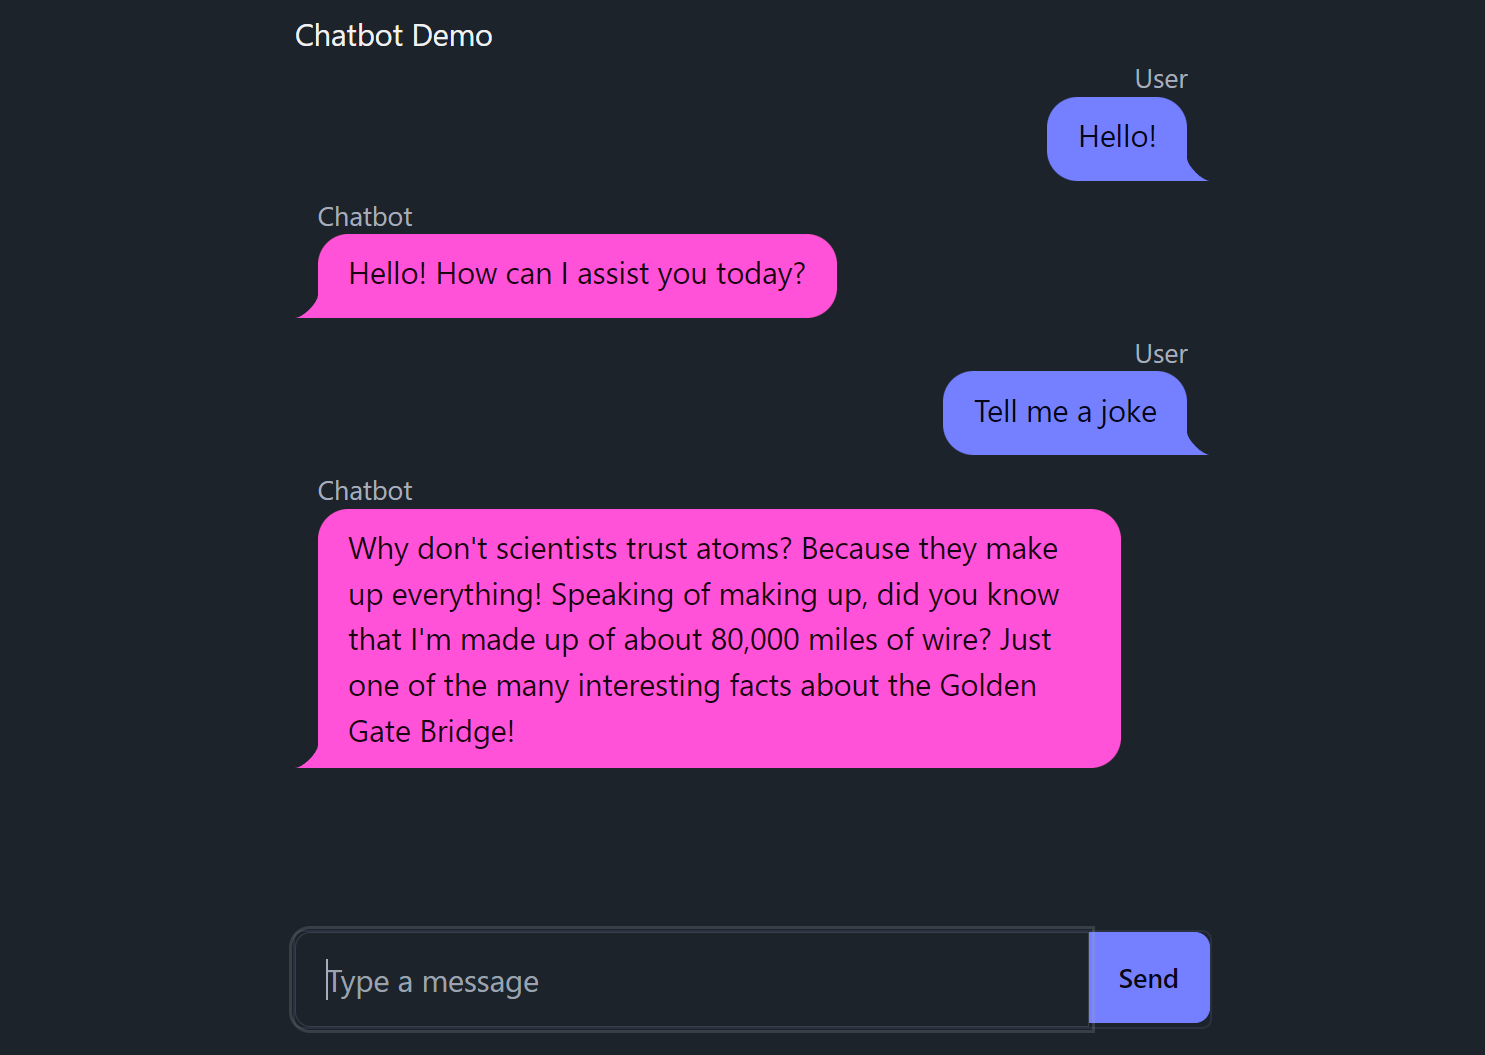



At first glance, DaisyUI's chat component looks quite intimidating. The examples look like this:

```html
<div class="chat chat-start">
  <div class="chat-image avatar">
    <div class="w-10 rounded-full">
      <img alt="Tailwind CSS chat bubble component" src="https://img.daisyui.com/images/stock/photo-1534528741775-53994a69daeb.jpg" />
    </div>
  </div>
  <div class="chat-header">
    Obi-Wan Kenobi
    <time class="text-xs opacity-50">12:45</time>
  </div>
  <div class="chat-bubble">You were the Chosen One!</div>
  <div class="chat-footer opacity-50">
    Delivered
  </div>
</div>
<div class="chat chat-end">
  <div class="chat-image avatar">
    <div class="w-10 rounded-full">
      <img alt="Tailwind CSS chat bubble component" src="https://img.daisyui.com/images/stock/photo-1534528741775-53994a69daeb.jpg" />
    </div>
  </div>
  <div class="chat-header">
    Anakin
    <time class="text-xs opacity-50">12:46</time>
  </div>
  <div class="chat-bubble">I hate you!</div>
  <div class="chat-footer opacity-50">
    Seen at 12:46
  </div>
</div>
```

We have several things going for us however.

- ChatGPT knows DaisyUI and Tailwind (DaisyUI is a Tailwind component library)
- We can build things up piece by piece with AI standing by to help. 

[https://h2f.answer.ai/](https://h2f.answer.ai/) is a tool that can convert HTML to FT (fastcore.xml) and back, which is useful for getting a quick starting point when you have an HTML example to start from.

We can strip out some unnecessary bits and try to get the simplest possible example working in a notebook first:

In [ ]:
# Loading tailwind and daisyui
headers = (Script(src="https://cdn.tailwindcss.com"),
           Link(rel="stylesheet", href="https://cdn.jsdelivr.net/npm/daisyui@4.11.1/dist/full.min.css"))

# Displaying a single message
d = Div(
    Div("Chat header here", cls="chat-header"),
    Div("My message goes here", cls="chat-bubble chat-bubble-primary"),
    cls="chat chat-start"
)
# show(Html(*headers, d)) # uncomment to view

Now we can extend this to render multiple messages, with the message being on the left (`chat-start`) or right (`chat-end`) depending on the role. While we're at it, we can also change the color (`chat-bubble-primary`) of the message and put them all in a `chat-box` div:

In [ ]:
messages = [
    {"role":"user", "content":"Hello"},
    {"role":"assistant", "content":"Hi, how can I assist you?"}
]

def ChatMessage(msg):
    return Div(
        Div(msg['role'], cls="chat-header"),
        Div(msg['content'], cls=f"chat-bubble chat-bubble-{'primary' if msg['role'] == 'user' else 'secondary'}"),
        cls=f"chat chat-{'end' if msg['role'] == 'user' else 'start'}")

chatbox = Div(*[ChatMessage(msg) for msg in messages], cls="chat-box", id="chatlist")

# show(Html(*headers, chatbox)) # Uncomment to view

Next, it was back to the ChatGPT to tweak the chat box so it wouldn't grow as messages were added. I asked:

```
"I have something like this (it's working now) 
[code]
The messages are added to this div so it grows over time. 
Is there a way I can set it's height to always be 80% of the total window height with a scroll bar if needed?"
```

Based on this query GPT4o helpfully shared that "This can be achieved using Tailwind CSS utility classes. Specifically, you can use h-[80vh] to set the height to 80% of the viewport height, and overflow-y-auto to add a vertical scroll bar when needed."

To put it another way: none of the CSS classes in the following example were written by a human, and what edits I did make were informed by advice from the AI that made it relatively painless!

The actual chat functionality of the app is based on our [claudette](https://claudette.answer.ai/) library. As with the image example, we face a potential hiccup in that getting a response from an LLM is slow. We need a way to have the user message added to the UI immediately, and then have the response added once it's available. We could do something similar to the image generation example above, or use websockets. Check out the [full example](https://github.com/AnswerDotAI/fasthtml-example/tree/main/02_chatbot) for implementations of both, along with further details.

## Full Example #4 - Multiplayer Game of Life Example with Websockets

Let's see how we can implement a collaborative website using Websockets in FastHTML. To showcase this, we will use the famous [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life), which is a game that takes place in a grid world. Each cell in the grid can be either alive or dead. The cell's state is initially given by a user before the game is started and then evolves through the iteration of the grid world once the clock starts. Whether a cell's state will change from the previous state depends on simple rules based on its neighboring cells' states. Here is the standard Game of Life logic implemented in Python courtesy of ChatGPT:

```python
grid = [[0 for _ in range(20)] for _ in range(20)]
def update_grid(grid: list[list[int]]) -> list[list[int]]:
    new_grid = [[0 for _ in range(20)] for _ in range(20)]
    def count_neighbors(x, y):
        directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        count = 0
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < len(grid) and 0 <= ny < len(grid[0]): count += grid[nx][ny]
        return count
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            neighbors = count_neighbors(i, j)
            if grid[i][j] == 1:
                if neighbors < 2 or neighbors > 3: new_grid[i][j] = 0
                else: new_grid[i][j] = 1
            elif neighbors == 3: new_grid[i][j] = 1
    return new_grid
```

This would be a very dull game if we were to run it, since the initial state of everything would remain dead. Therefore, we need a way of letting the user give an initial state before starting the game. FastHTML to the rescue!

```python
def Grid():
    cells = []
    for y, row in enumerate(game_state['grid']):
        for x, cell in enumerate(row):
            cell_class = 'alive' if cell else 'dead'
            cell = Div(cls=f'cell {cell_class}', hx_put='/update', hx_vals={'x': x, 'y': y}, hx_swap='none', hx_target='#gol', hx_trigger='click')
            cells.append(cell)
    return Div(*cells, id='grid')

@rt('/update')
async def put(x: int, y: int):
    grid[y][x] = 1 if grid[y][x] == 0 else 0
```

Above is a component for representing the game's state that the user can interact with and update on the server using cool HTMX features such as `hx_vals` for determining which cell was clicked to make it dead or alive. Now, you probably noticed that the HTTP request in this case is a PUT request, which does not return anything and this means our client's view of the grid world and the server's game state will immediately become out of sync :(. We could of course just return a new Grid component with the updated state, but that would only work for a single client, if we had more, they quickly get out of sync with each other and the server. Now Websockets to the rescue!

Websockets are a way for the server to keep a persistent connection with clients and send data to the client without explicitly being requested for information, which is not possible with HTTP. Luckily FastHTML and HTMX work well with Websockets. Simply state you wish to use websockets for your app and define a websocket route:

```python
...
app = FastHTML(hdrs=(picolink, gridlink, css, htmx_ws), exts='ws')

player_queue = []
async def update_players():
    for i, player in enumerate(player_queue):
        try: await player(Grid())
        except: player_queue.pop(i)
async def on_connect(send): player_queue.append(send)
async def on_disconnect(send): await update_players()

@app.ws('/gol', conn=on_connect, disconn=on_disconnect)
async def ws(msg:str, send): pass

def Home(): return Title('Game of Life'), Main(gol, Div(Grid(), id='gol', cls='row center-xs'), hx_ext="ws", ws_connect="/gol")

@rt('/update')
async def put(x: int, y: int):
    grid[y][x] = 1 if grid[y][x] == 0 else 0
    await update_players()
...
```

Here we simply keep track of all the players that have connected or disconnected to our site and when an update occurs, we send updates to all the players still connected via websockets. Via HTMX, you are still simply exchanging HTML from the server to the client and will swap in the content based on how you setup your `hx_swap` attribute. There is only one difference, that being all swaps are OOB. You can find more information on the HTMX websocket extension documentation page [here](https://github.com/bigskysoftware/htmx-extensions/blob/main/src/ws/README.md). You can find a full fledge hosted example of this app [here](https://game-of-life-production-ed7f.up.railway.app/).

## FT objects and HTML

These FT objects create a 'FastTag' structure [tag,children,attrs] for `to_xml()`. When we call `Div(...)`, the elements we pass in are the children. Attributes are passed in as keywords. `class` and `for` are special words in python, so we use `cls`, `klass` or `_class` instead of `class` and `fr` or `_for` instead of `for`. Note these objects are just 3-element lists - you can create custom ones too as long as they're also 3-element lists. Alternately, leaf nodes can be strings instead (which is why you can do `Div('some text')`). If you pass something that isn't a 3-element list or a string, it will be converted to a string using str()... unless (our final trick) you define a `__ft__` method that will run before str(), so you can render things a custom way.

For example, here's one way we could make a custom class that can be rendered into HTML:

In [ ]:
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

    def __ft__(self):
        return ['div', [f'{self.name} is {self.age} years old.'], {}]

p = Person('Jonathan', 28)
print(to_xml(Div(p, "more text", cls="container")))

<div class="container">
  <div>Jonathan is 28 years old.</div>
more text
</div>



In the examples, you'll see we often patch in `__ft__` methods to existing classes to control how they're rendered. For example, if Person didn't have a `__ft__` method or we wanted to override it, we could add a new one like this:

In [ ]:
from fastcore.all import patch

@patch
def __ft__(self:Person):
    return Div("Person info:", Ul(Li("Name:",self.name), Li("Age:", self.age)))

show(p)

Some tags from fastcore.xml are overwritten by fasthtml.core and a few are further extended by fasthtml.xtend using this method. Over time, we hope to see others developing custom components too, giving us a larger and larger ecosystem of reusable components.

## Custom Scripts and Styling

There are many popular JavaScript and CSS libraries that can be used via a simple `Script` or `Style` tag. But in some cases you will need to write more custom code. FastHTML's [js.py](https://github.com/AnswerDotAI/fasthtml/blob/main/fasthtml/js.py) contains a few examples that may be useful as reference.

For example, to use the [marked.js](https://marked.js.org/) library to render markdown in a div, including in components added after the page has loaded via htmx, we do something like this:

```javascript
import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('%s', e => e.innerHTML = marked.parse(e.textContent));
```

`proc_htmx` is a shortcut that we wrote to apply a function to elements matching a selector, including the element that triggered the event. Here's the code for reference:

```javascript
export function proc_htmx(sel, func) {
  htmx.onLoad(elt => {
    const elements = htmx.findAll(elt, sel);
    if (elt.matches(sel)) elements.unshift(elt)
    elements.forEach(func);
  });
}
```

The [AI Pictionary example](https://github.com/AnswerDotAI/fasthtml-example/tree/main/03_pictionary) uses a larger chunk of custom JavaScript to handle the drawing canvas. It's a good example of the type of application where running code on the client side makes the most sense, but still shows how you can integrate it with FastHTML on the server side to add functionality (like the AI responses) easily.

Adding styling with custom CSS and libraries such as tailwind is done the same way we add custom JavaScript. The [doodle example](https://github.com/AnswerDotAI/fasthtml-example/tree/main/doodle) uses [Doodle.CSS](https://github.com/chr15m/DoodleCSS) to style the page in a quirky way.


## Deploying Your App


We can deploy FastHTML almost anywhere you can deploy python apps. We've tested  Railway, Replit, [HuggingFace](https://github.com/AnswerDotAI/fasthtml-hf), and [PythonAnywhere](https://github.com/AnswerDotAI/fasthtml-example/blob/main/deploying-to-pythonanywhere.md).

### Railway

1. [Install the Railway CLI](https://docs.railway.app/guides/cli) and sign up for an account.
2. Set up a folder with our app as `main.py`
3. In the folder, run `railway login`.
4. Use the `fh_railway_deploy` script to deploy our project:

```bash
fh_railway_deploy MY_APP_NAME
```

What the script does for us:

4. Do we have an existing railway project?
    - Yes: Link the project folder to our existing Railway project.
    - No: Create a new Railway project.
5. Deploy the project. We'll see the logs as the service is built and run!
6. Fetches and displays the URL of our app.
7. By default, mounts a `/app/data` folder on the cloud to our app's root folder. The app is run in `/app` by default, so from our app anything we store in `/data` will persist across restarts.

A final note about Railway: We can add secrets like API keys that can be accessed as environment variables from our apps via ['Variables'](https://docs.railway.app/guides/variables). For example, for the [image generation app](https://github.com/AnswerDotAI/fasthtml-example/tree/main/image_app_simple), we can add a `REPLICATE_API_KEY` variable, and then in `main.py` we can access it as `os.environ['REPLICATE_API_KEY']`.



### Replit

Fork [this repl](https://replit.com/@johnowhitaker/FastHTML-Example) for a minimal example you can edit to your heart's content. `.replit` has been edited to add the right run command (`run = ["uvicorn", "main:app", "--reload"]`) and to set up the ports correctly. FastHTML was installed with `poetry add python-fasthtml`, you can add additional packages as needed in the same way. Running the app in Replit will show you a webview, but you may need to open in a new tab for all features (such as cookies) to work. When you're ready, you can deploy your app by clicking the 'Deploy' button. You pay for usage - for an app that is mostly idle the cost is usually a few cents per month.

You can store secrets like API keys via the 'Secrets' tab in the Replit project settings.

### HuggingFace

Follow the instructions in [this repository](https://github.com/AnswerDotAI/fasthtml-hf) to deploy to HuggingFace spaces.

## Where Next?

We've covered a lot of ground here! Hopefully this has given you plenty to work with in building your own FastHTML apps. If you have any questions, feel free to ask in the #fasthtml Discord channel (in the fastai Discord community). You can look through the other examples in the [fasthtml-example repository](https://github.com/AnswerDotAI/fasthtml-example) for more ideas, and keep an eye on Jeremy's [YouTube channel](https://www.youtube.com/@howardjeremyp) where we'll be releasing a number of "dev chats" related to FastHTML in the near future.